### Importing the necessary libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Defining constants

In [11]:
M   = 1e30        # Mass of the star (in kg)
ME  = 5.972e24    # Mass of the earth (in kg)
G   = 6.6743e-11  # Universal gravitation constant
AU  = 150e9       # 1 Astronomical unit (in m)
SPD = 24*60*60    # No of seconds in 1 day

### Concepts used
- Raw observed data is noisy, hence, it is processed via fourier sampling to reduce noise to a great extent
- The number of peaks in the fourier graph corresponds to the number of exoplanets present
- For each planet,
    - Maximum Radial Velocity influence on the star = v
    - Time period of revolution = t = Distance between 2 peaks
    - Angular velocity of revolution = Omega ($\omega$) = 2 $\pi$/t
    - $M_{s}/M_{p} = R_{p}/R_{s} = x$ (say)
        - $M_{s}$ = Mass of the star (given)
        - $R_{s}$ = Distance between CoM of the Star-Planet system and center of star = $v / \omega$
        - $M_{p}$ = mass of the exoplanet
        - $R_{p}$ = Distance between CoM of the Star-Planet system and center of exoplanet
    - From the law of gravitation,
    
    $\frac{GM_{s}M_{p}}{(R_{s}+R_{p})^{2}}$ = $M_{p}R_{p}\omega^{2}$
    
    $\frac{GM_{s}}{R_{s}v^{2}}$ = $x(x+1)^2$ $\approx$ $x^{3}$ 

### Star
The class has the following variables:
- private:
    - **__fourier_power**: Power array obtained on discrete fourier transform of raw data
    - **__fourier_freq**: Frequency array obtained on discrete fourier transform of raw data
    - **__planets_influence**: Radial velocity contribution of each planet
- public"
    - **time**: The time array
    - **raw_vel**: The raw observed raial velocity of the star
    - **M**: Mass of the star
    - **corrected_vel**: The corrected velocity post noise reduction
    - **planets**: Details of the planets

In [12]:
class Star():
    def __init__(self, time, raw_vel, M):
        self.time = np.array(time)
        self.raw_vel = np.array(raw_vel)
        self.M = M
        self.__fourier_power, self.__fourier_freq = self.__calc_fourier_transform()
        self.corrected_vel = self.__calc_corrected_vel()
        self.__planets_influence = self.__calc_planets_influence()
        self.planets = self.__calc_planet_data()

    def __calc_fourier_transform(self):
        __power = np.fft.rfft(self.raw_vel)
        __freq = np.fft.rfftfreq(len(self.raw_vel), (self.time[1]-self.time[0]))
        zeros = np.where(np.abs(__power) < 50)
        __power[zeros] = 0
        __power[0] = 0
        return __power, __freq

    def __calc_corrected_vel(self):
        return np.fft.irfft(self.__fourier_power)

    def __calc_planets_influence(self):
        indices = np.where(np.abs(self.__fourier_power) > 0)
        __vel = []
        for i in range(len(indices[0])):
            __indices = np.where(np.abs(self.__fourier_power) != np.abs(self.__fourier_power[indices[0][i]]))
            __power = self.__fourier_power.copy()
            __power[__indices] = 0
            __inverse = np.fft.irfft(__power)
            __vel.append(__inverse)
        return __vel

    def __calc_planet_data(self):
        global G
        __planets = []
        for i in range(len(self.__planets_influence)):
            v = self.__planets_influence[i].max()
            __indices = []
            for j in range(1, len(self.__planets_influence[i])-1):
                if (self.__planets_influence[i][j-1]<self.__planets_influence[i][j]) and (self.__planets_influence[i][j]>self.__planets_influence[i][j+1]):
                    __indices.append(j)
                if (len(__indices) == 2):
                    break
            t = self.time[__indices[1]] - self.time[__indices[0]]
            omega = 2 * np.pi / t
            R = v / omega
            x = np.cbrt((G * self.M) / (v * v * R))
            r = (x+1) * R
            m = self.M / (x + 1)
            planet_data = {
                "radius": r+R,
                "mass": m,
                "omega": omega,
                "time_period": t
            }
            __planets.append(planet_data)
        return __planets

    def print_planet_details(self, n):
        global ME, AU
        if (n>len(self.planets)) or (n<0):
            print("Exoplanet not found! Enter a number between 1 and {}".format(len(self.planets)+1))
            return
        print("Details of Exoplanet #{}:".format(n+1))
        print("    Mass of the Exoplanet     = {} Earth masses".format(round(self.planets[n]["mass"]/ME, 2)))
        print("    Radius of Revolution      = {} AU".format(round(self.planets[n]["radius"]/AU, 2)))
        print("    Time Period of Revolution = {} Earth years".format(round(self.planets[n]["time_period"]/(SPD*365), 2)))
        # print("    Angular Velocity of Revolution = {} sec^-1".format(self.planets[n-1]["omega"]))

    def plot_raw_vel(self):
        plt.figure(figsize=(30, 10))
        plt.scatter(self.time, self.raw_vel, s=0.3)
        plt.xlabel("Time (in s)")
        plt.ylabel("Radial Velocity (in m/s)")
        plt.grid()
        plt.show()

    def plot_fourier_transform(self):
        plt.figure(figsize=(30, 10))
        plt.plot(self.__fourier_freq[0:100], np.abs(self.__fourier_power)[0:100])
        plt.xlabel("Frequency (in $s^{-1}$)")
        plt.ylabel("Power")
        plt.grid()
        plt.show()

    def plot_corrected_vel(self):
        plt.figure(figsize=(30, 15))
        plt.plot(self.time, self.corrected_vel)
        plt.xlabel("Time (in s)")
        plt.ylabel("Radial Velocity (in m/s)")
        plt.grid()
        plt.show()

    def plot_individual_planet_influence(self):
        plt.figure(figsize=(30, 10))
        for __vel in self.__planets_influence:
            plt.plot(self.time, __vel)
        plt.xlabel("Time (in s)")
        plt.ylabel("Stellar Velocity (in m/s)")
        plt.grid()
        plt.show()

### Reading data

In [13]:
df = pd.read_csv('astrometry_data.csv')
time = df[df.columns[0]]
vel = df[df.columns[1]]

### Plotting the raw data

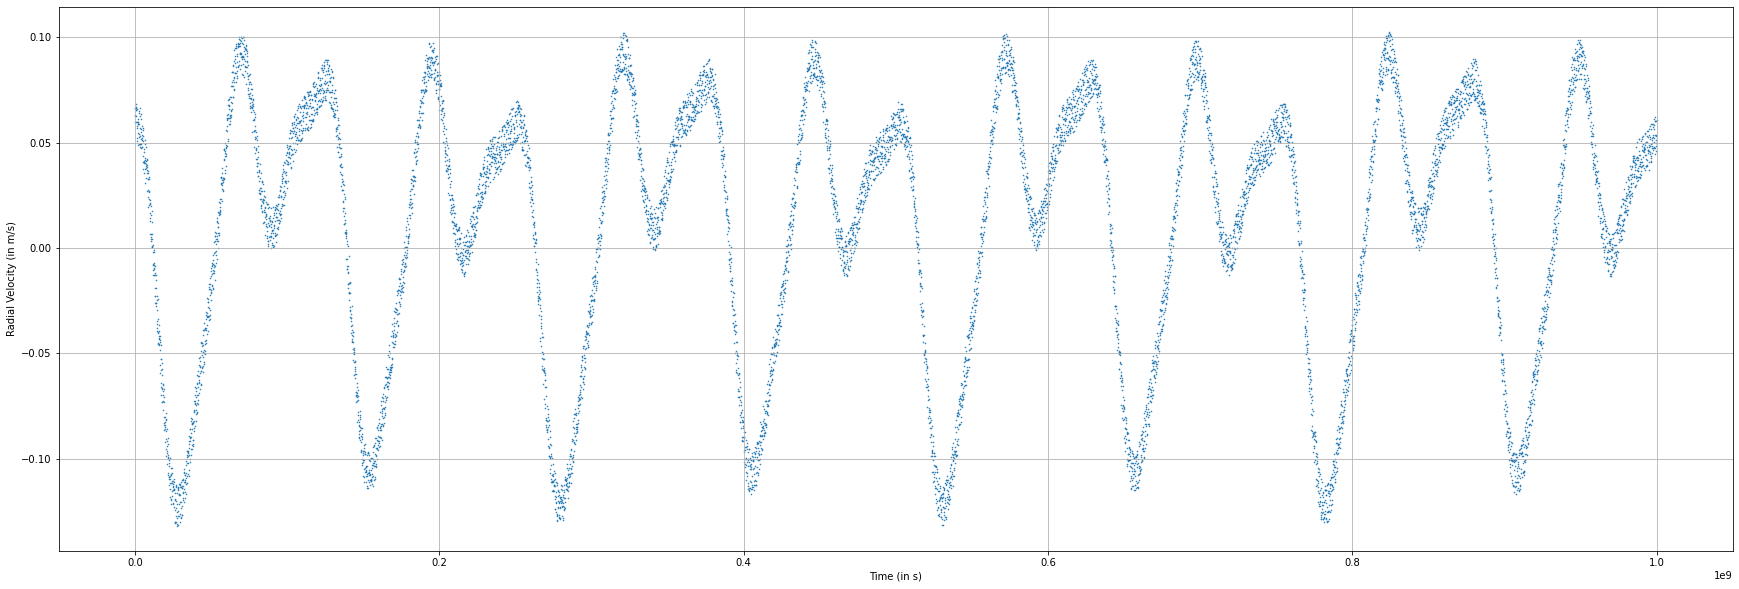

In [14]:
star = Star(time, vel, M)
star.plot_raw_vel()

### Plotting the fourier transform

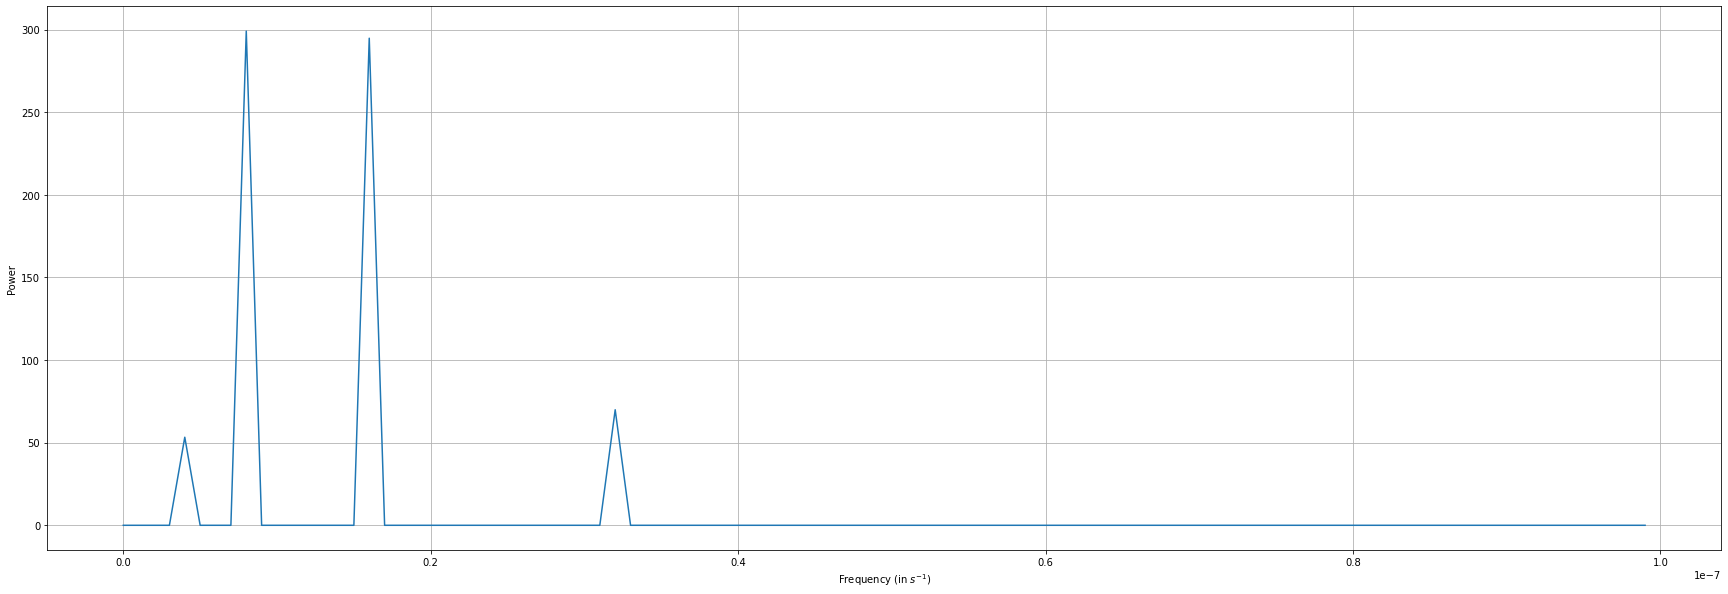

In [15]:
star.plot_fourier_transform()

### Plotting the corrected (noise-reduced) velocity

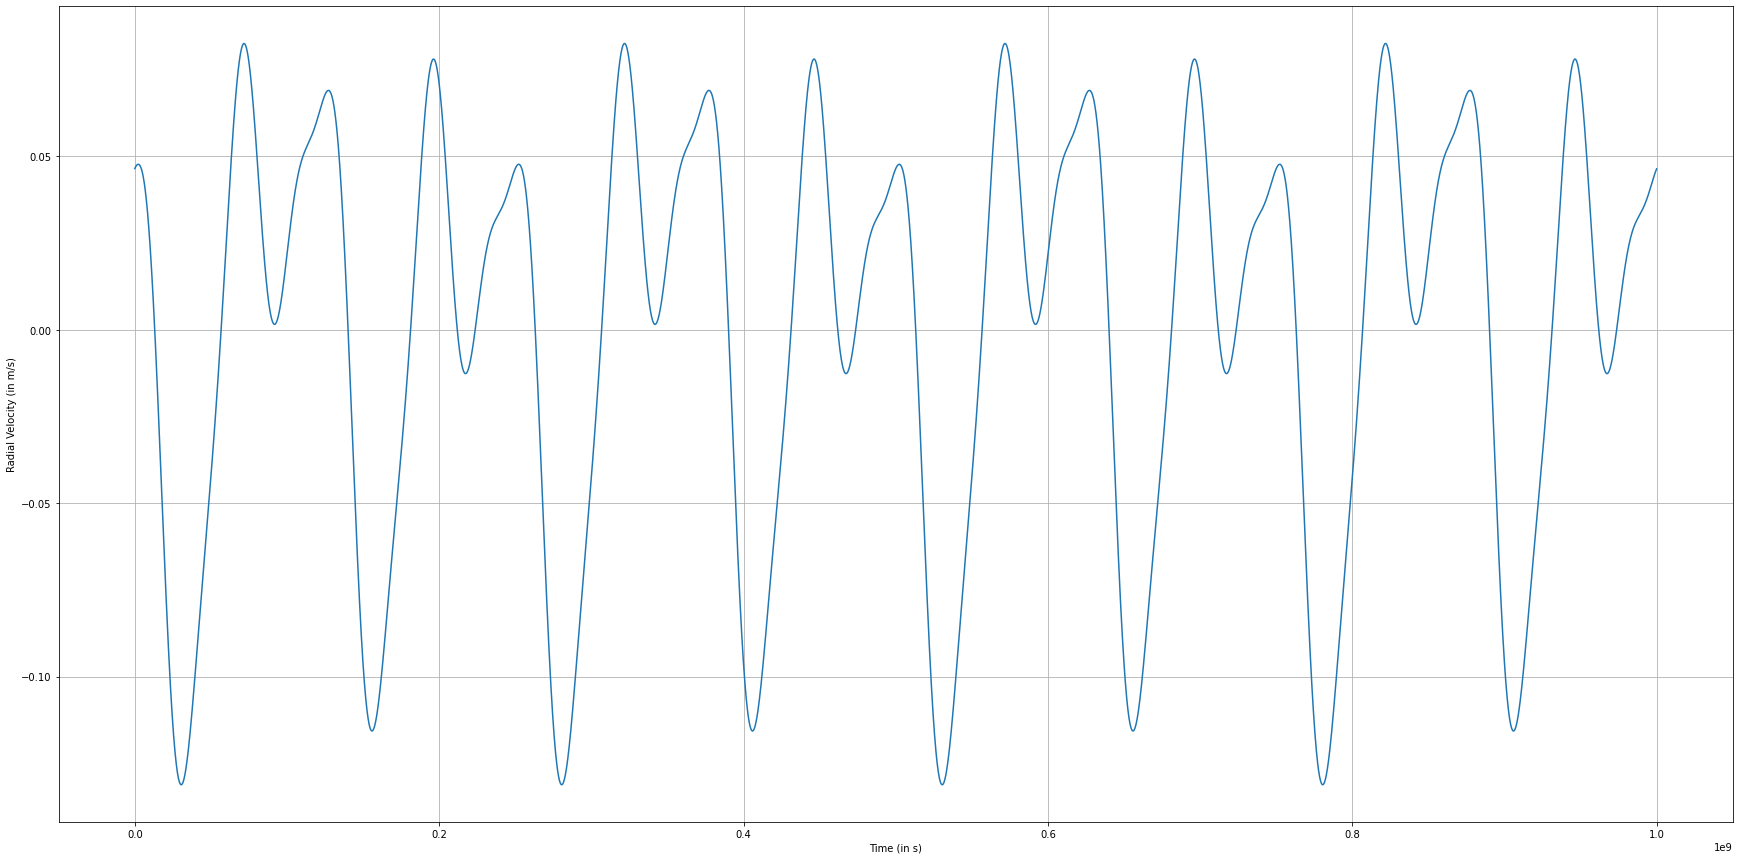

In [16]:
star.plot_corrected_vel()

### Plotting influence due to each exoplanet

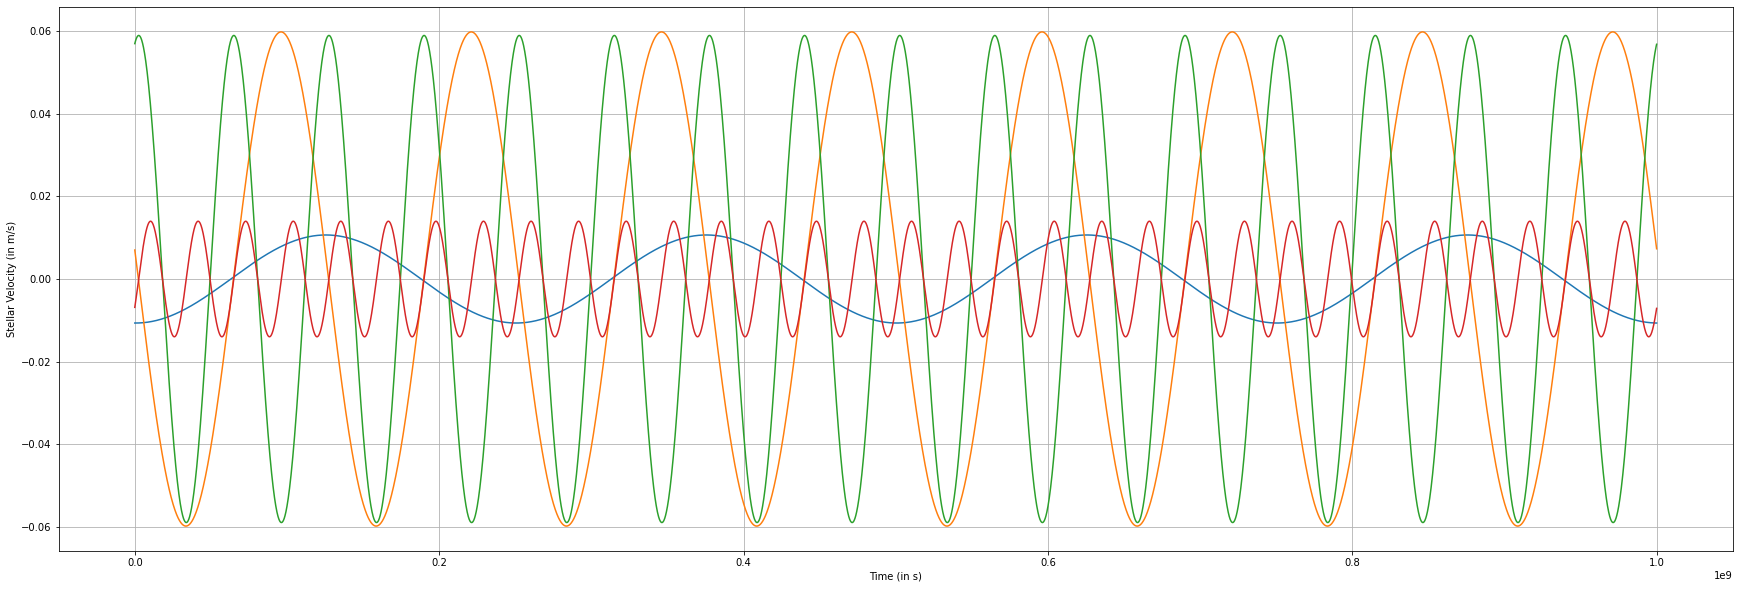

In [17]:
star.plot_individual_planet_influence()

### Printing details of exoplanets found

In [18]:
for i in range(len(star.planets)):
    star.print_planet_details(i)
    print("")

Details of Exoplanet #1:
    Mass of the Exoplanet     = 0.15 Earth masses
    Radius of Revolution      = 3.15 AU
    Time Period of Revolution = 7.93 Earth years

Details of Exoplanet #2:
    Mass of the Exoplanet     = 0.67 Earth masses
    Radius of Revolution      = 1.99 AU
    Time Period of Revolution = 3.96 Earth years

Details of Exoplanet #3:
    Mass of the Exoplanet     = 0.52 Earth masses
    Radius of Revolution      = 1.25 AU
    Time Period of Revolution = 1.98 Earth years

Details of Exoplanet #4:
    Mass of the Exoplanet     = 0.1 Earth masses
    Radius of Revolution      = 0.79 AU
    Time Period of Revolution = 0.99 Earth years

